In [60]:
# Compile command
run(`gcc N35_BoxQP.c -o N35_BoxQP.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)
run(`gcc N3_BoxQP_dsyr.c -o N3_BoxQP_dsyr.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)

# define the interface call
const N35_BoxQP_lib = "./N35_BoxQP.so"
function call_N35_BoxQP(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N35_BoxQP, N35_BoxQP_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,n,z
    )
    return z
end

const N3_BoxQP_dsyr_lib = "./N3_BoxQP_dsyr.so"
function call_N3_BoxQP_dsyr(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64,delta::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N3_BoxQP_dsyr, N3_BoxQP_dsyr_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,delta,n,z
    )
    return z
end

call_N3_BoxQP_dsyr (generic function with 1 method)

In [69]:
using Random, LinearAlgebra, Statistics, SparseArrays, Plots, JuMP, Ipopt, OSQP

Random.seed!(20230914)

N = 1000
lambda = 2
x0 = 5*ones(3,1)
P0 = I(3)
Q = Diagonal([1/40,1/10,1/5])
R = 0.5*I(2)

v = (randn(N,3)*cholesky(Q).L)' # process noise

# Vector for full state history:
x = zeros(3,N+1)
x[:,1] = x0 + cholesky(P0).L * randn(3)

u = zeros(N)
u[1:500] .= 5
u[501:end] .= 2
alpha1 = 0.1
alpha2 = 0.5
alpha3 = 0.2

A = [1-alpha1 0 0;
    0 1-alpha2 0;
    alpha1 alpha2 1-alpha3]
B = [0.5; 0.5; 0]

# Vector for full measurement history:
z = zeros(2,N+1)
H = [1 0 0; 0 0 1]
w = (randn(N+1,2)*cholesky(R).L)' # measurement noise

# Additional noise term: Simulate sensor failures
y = zeros(2,N+1)
numberofOnes = Int(N/20)

indexes = randperm(N)
for i in 1:numberofOnes
    y[1,indexes[i]] = 25*randn()
end

indexes = randperm(N)
for i in 1:numberofOnes
    y[2,indexes[i]] = 25*randn()
end

# Simulation
for k in 2:N+1
    x[:,k] = A*x[:,k-1] + B*u[k-1] + v[:,k-1]
    z[:,k] = H*x[:,k] + w[:,k] + y[:,k]
end

# Kalman Filter 
x_hat = zeros(3,N+1)
x_hat[:,1] = x0
P_hat = P0
R_inv = inv(R)
for k in 2:N+1
    x_p = A*x_hat[:,k-1] + B*u[k-1]
    P_p = A*P_hat*A' + Q

    P_hat = inv(inv(P_p)+H'*R_inv*H)
    x_hat[:,k] = x_p + P_hat*H'*R_inv*(z[:,k]-H*x_p)
end

# Robust Kalman Filter 
Run_time_Hist = []
x_hat_RKF = zeros(3,N+1);
x_hat_RKF[:,1] = x0;
P_hat_RKF = P0;
for k in 2:N+1
    x_p_RKF = A*x_hat_RKF[:,k-1] + B*u[k-1];
    P_p_RKF = A*P_hat_RKF*A' + Q;

    P_hat_RKF = inv(inv(P_p_RKF)+H'*R_inv*H);

    L = P_hat_RKF*H'*inv(H*P_hat_RKF*H'+R);
    myQ = (I(2)-H*L)'*R_inv*(I(2)-H*L)+L'*inv(P_hat_RKF)*L;
    e_k = z[:,k]-H*x_p_RKF;

    
    H_inv = inv(myQ)
    f = myQ*e_k
    h = -H_inv*f

    start_time = time()
    sol = call_N3_BoxQP_dsyr(H_inv,h,1e-6,0.3,0.15);
    run_time = time() - start_time
    
    Run_time_Hist = [Run_time_Hist; run_time]
    sol = H_inv*(f-sol)

    x_hat_RKF[:,k] = x_p_RKF + L*(e_k-sol);
end

# evaluate error
RMS_KF = zeros(3,N+1);
for i in 1:3
    RMS_KF[i,:] = sqrt.((x[i,:].-x_hat[i,:]).^2/N);
end

RMS_RKF = zeros(3,N+1);
for i in 1:3
    RMS_RKF[i,:] = sqrt.((x[i,:].-x_hat_RKF[i,:]).^2/N);
end

for i in 1:3
    imp = 100-100/mean(RMS_KF[i,:])*mean(RMS_RKF[i,:]);
    println("RMS error of state $i estimate is reduced by $imp percent")
end

computation_time = mean(Run_time_Hist)
println("The average computation of our N3QP solver is $computation_time seconds")

RMS error of state 1 estimate is reduced by 64.70385579670995 percent
RMS error of state 2 estimate is reduced by 11.345938384684061 percent
RMS error of state 3 estimate is reduced by 54.68958634430398 percent
The average computation of our N3QP solver is 4.417133331298828e-5 seconds


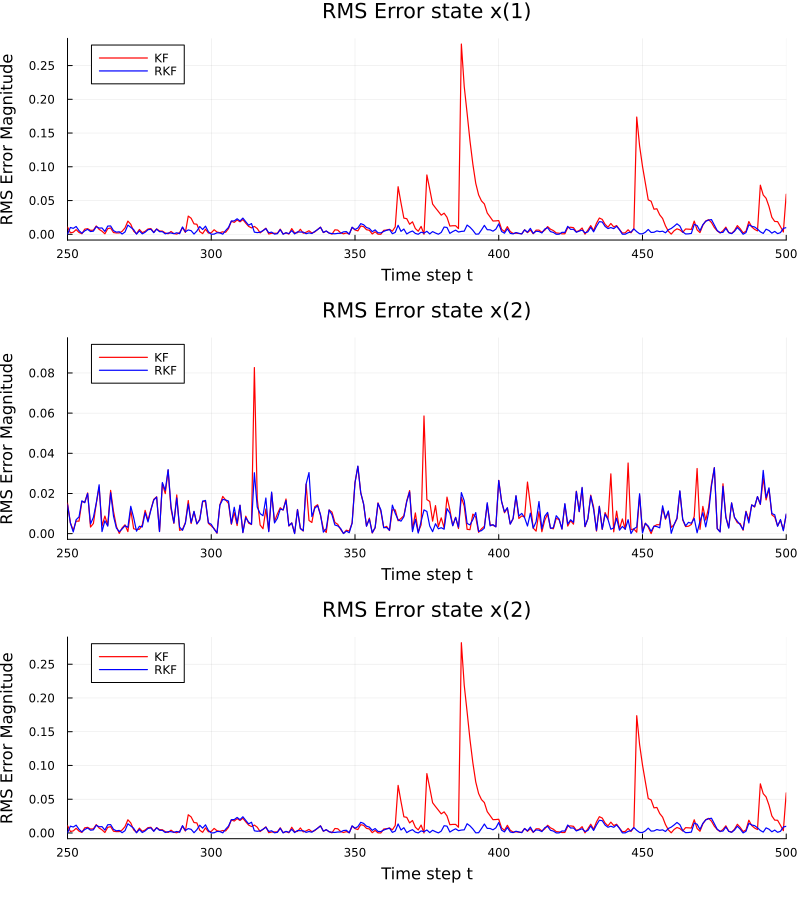

In [70]:
t=0:N
plot(layout=(3,1),size=(800,900))
plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=1)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=1,legend=:topleft)
title!("RMS Error state x(1)", subplot=1,fontsize=12)
xlabel!("Time step t", subplot=1)
ylabel!("RMS Error Magnitude",subplot=1)
xlims!(subplot=1,(250,500))


plot!(t,RMS_KF[2,:],color=:red,linewidth=1.2,label="KF",subplot=2)
plot!(t,RMS_RKF[2,:],color=:blue,linewidth=1.2,label="RKF",subplot=2,legend=:topleft)
title!("RMS Error state x(2)", subplot=2,fontsize=12)
xlabel!("Time step t", subplot=2)
ylabel!("RMS Error Magnitude",subplot=2)
xlims!(subplot=2,(250,500))

plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=3)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=3,legend=:topleft)
title!("RMS Error state x(2)", subplot=3,fontsize=12)
xlabel!("Time step t", subplot=3)
ylabel!("RMS Error Magnitude",subplot=3)
xlims!(subplot=3,(250,500))

In [71]:
# calculting the computation time of N35_QP solver

Random.seed!(20230914)

N = 1000
lambda = 2
x0 = 5*ones(3,1)
P0 = I(3)
Q = Diagonal([1/40,1/10,1/5])
R = 0.5*I(2)

v = (randn(N,3)*cholesky(Q).L)' # process noise

# Vector for full state history:
x = zeros(3,N+1)
x[:,1] = x0 + cholesky(P0).L * randn(3)

u = zeros(N)
u[1:500] .= 5
u[501:end] .= 2
alpha1 = 0.1
alpha2 = 0.5
alpha3 = 0.2

A = [1-alpha1 0 0;
    0 1-alpha2 0;
    alpha1 alpha2 1-alpha3]
B = [0.5; 0.5; 0]

# Vector for full measurement history:
z = zeros(2,N+1)
H = [1 0 0; 0 0 1]
w = (randn(N+1,2)*cholesky(R).L)' # measurement noise

# Additional noise term: Simulate sensor failures
y = zeros(2,N+1)
numberofOnes = Int(N/20)

indexes = randperm(N)
for i in 1:numberofOnes
    y[1,indexes[i]] = 25*randn()
end

indexes = randperm(N)
for i in 1:numberofOnes
    y[2,indexes[i]] = 25*randn()
end

# Simulation
for k in 2:N+1
    x[:,k] = A*x[:,k-1] + B*u[k-1] + v[:,k-1]
    z[:,k] = H*x[:,k] + w[:,k] + y[:,k]
end

# Kalman Filter 
x_hat = zeros(3,N+1)
x_hat[:,1] = x0
P_hat = P0
R_inv = inv(R)
for k in 2:N+1
    x_p = A*x_hat[:,k-1] + B*u[k-1]
    P_p = A*P_hat*A' + Q

    P_hat = inv(inv(P_p)+H'*R_inv*H)
    x_hat[:,k] = x_p + P_hat*H'*R_inv*(z[:,k]-H*x_p)
end

# Robust Kalman Filter 
Run_time_Hist = []
x_hat_RKF = zeros(3,N+1);
x_hat_RKF[:,1] = x0;
P_hat_RKF = P0;
for k in 2:N+1
    x_p_RKF = A*x_hat_RKF[:,k-1] + B*u[k-1];
    P_p_RKF = A*P_hat_RKF*A' + Q;

    P_hat_RKF = inv(inv(P_p_RKF)+H'*R_inv*H);

    L = P_hat_RKF*H'*inv(H*P_hat_RKF*H'+R);
    myQ = (I(2)-H*L)'*R_inv*(I(2)-H*L)+L'*inv(P_hat_RKF)*L;
    e_k = z[:,k]-H*x_p_RKF;

    
    H_inv = inv(myQ)
    f = myQ*e_k
    h = -H_inv*f
    
    start_time = time()
    sol = call_N35_BoxQP(H_inv,h,1e-6,0.3)
    run_time = time() - start_time

    Run_time_Hist = [Run_time_Hist; run_time]
    sol = H_inv*(f-sol);

    x_hat_RKF[:,k] = x_p_RKF + L*(e_k-sol);
end

# evaluate error
RMS_KF = zeros(3,N+1);
for i in 1:3
    RMS_KF[i,:] = sqrt.((x[i,:].-x_hat[i,:]).^2/N);
end

RMS_RKF = zeros(3,N+1);
for i in 1:3
    RMS_RKF[i,:] = sqrt.((x[i,:].-x_hat_RKF[i,:]).^2/N);
end

for i in 1:3
    imp = 100-100/mean(RMS_KF[i,:])*mean(RMS_RKF[i,:]);
    println("RMS error of state $i estimate is reduced by $imp percent")
end

computation_time = mean(Run_time_Hist)
println("The average computation of our Ipopt solver is $computation_time seconds")

RMS error of state 1 estimate is reduced by 64.70385871653512 percent
RMS error of state 2 estimate is reduced by 11.345938086315883 percent
RMS error of state 3 estimate is reduced by 54.68958562418144 percent
The average computation of our Ipopt solver is 4.324102401733399e-5 seconds


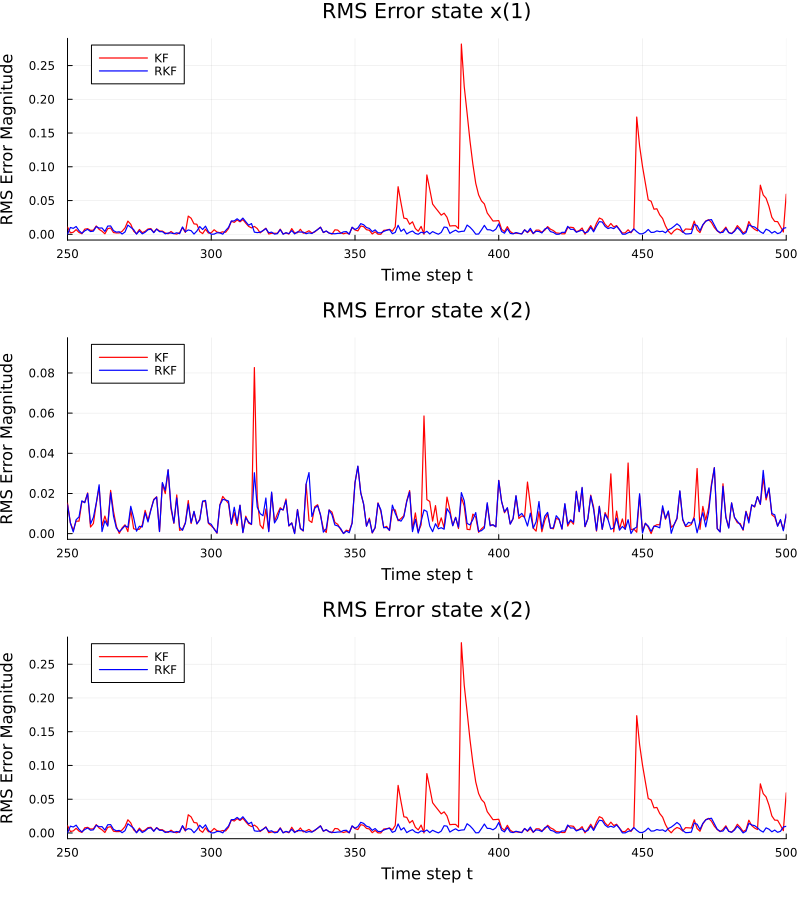

In [64]:
t=0:N
plot(layout=(3,1),size=(800,900))
plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=1)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=1,legend=:topleft)
title!("RMS Error state x(1)", subplot=1,fontsize=12)
xlabel!("Time step t", subplot=1)
ylabel!("RMS Error Magnitude",subplot=1)
xlims!(subplot=1,(250,500))


plot!(t,RMS_KF[2,:],color=:red,linewidth=1.2,label="KF",subplot=2)
plot!(t,RMS_RKF[2,:],color=:blue,linewidth=1.2,label="RKF",subplot=2,legend=:topleft)
title!("RMS Error state x(2)", subplot=2,fontsize=12)
xlabel!("Time step t", subplot=2)
ylabel!("RMS Error Magnitude",subplot=2)
xlims!(subplot=2,(250,500))

plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=3)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=3,legend=:topleft)
title!("RMS Error state x(2)", subplot=3,fontsize=12)
xlabel!("Time step t", subplot=3)
ylabel!("RMS Error Magnitude",subplot=3)
xlims!(subplot=3,(250,500))

In [72]:
# calculting the computation time of Ipopt solver

Random.seed!(20230914)

N = 1000
lambda = 2
x0 = 5*ones(3,1)
P0 = I(3)
Q = Diagonal([1/40,1/10,1/5])
R = 0.5*I(2)

v = (randn(N,3)*cholesky(Q).L)' # process noise

# Vector for full state history:
x = zeros(3,N+1)
x[:,1] = x0 + cholesky(P0).L * randn(3)

u = zeros(N)
u[1:500] .= 5
u[501:end] .= 2
alpha1 = 0.1
alpha2 = 0.5
alpha3 = 0.2

A = [1-alpha1 0 0;
    0 1-alpha2 0;
    alpha1 alpha2 1-alpha3]
B = [0.5; 0.5; 0]

# Vector for full measurement history:
z = zeros(2,N+1)
H = [1 0 0; 0 0 1]
w = (randn(N+1,2)*cholesky(R).L)' # measurement noise

# Additional noise term: Simulate sensor failures
y = zeros(2,N+1)
numberofOnes = Int(N/20)

indexes = randperm(N)
for i in 1:numberofOnes
    y[1,indexes[i]] = 25*randn()
end

indexes = randperm(N)
for i in 1:numberofOnes
    y[2,indexes[i]] = 25*randn()
end

# Simulation
for k in 2:N+1
    x[:,k] = A*x[:,k-1] + B*u[k-1] + v[:,k-1]
    z[:,k] = H*x[:,k] + w[:,k] + y[:,k]
end

# Kalman Filter 
x_hat = zeros(3,N+1)
x_hat[:,1] = x0
P_hat = P0
R_inv = inv(R)
for k in 2:N+1
    x_p = A*x_hat[:,k-1] + B*u[k-1]
    P_p = A*P_hat*A' + Q

    P_hat = inv(inv(P_p)+H'*R_inv*H)
    x_hat[:,k] = x_p + P_hat*H'*R_inv*(z[:,k]-H*x_p)
end

# Robust Kalman Filter 
Run_time_Hist = []
x_hat_RKF = zeros(3,N+1);
x_hat_RKF[:,1] = x0;
P_hat_RKF = P0;
for k in 2:N+1
    x_p_RKF = A*x_hat_RKF[:,k-1] + B*u[k-1];
    P_p_RKF = A*P_hat_RKF*A' + Q;

    P_hat_RKF = inv(inv(P_p_RKF)+H'*R_inv*H);

    L = P_hat_RKF*H'*inv(H*P_hat_RKF*H'+R);
    myQ = (I(2)-H*L)'*R_inv*(I(2)-H*L)+L'*inv(P_hat_RKF)*L;
    e_k = z[:,k]-H*x_p_RKF;

    
    H_inv = inv(myQ)
    f = myQ*e_k
    h = -H_inv*f
    
    model_ipopt = Model(Ipopt.Optimizer)
    set_attribute(model_ipopt,"print_level",0)
    @variable(model_ipopt,-1.0<=s[i=1:length(h)]<=1.0)
    @objective(model_ipopt,Min,0.5*s'*H_inv*s+h'*s)
    start_time = time()
    optimize!(model_ipopt)
    run_time = time() - start_time
    sol = value(s)

    Run_time_Hist = [Run_time_Hist; run_time]
    sol = H_inv*(f-sol);

    x_hat_RKF[:,k] = x_p_RKF + L*(e_k-sol);
end

# evaluate error
RMS_KF = zeros(3,N+1);
for i in 1:3
    RMS_KF[i,:] = sqrt.((x[i,:].-x_hat[i,:]).^2/N);
end

RMS_RKF = zeros(3,N+1);
for i in 1:3
    RMS_RKF[i,:] = sqrt.((x[i,:].-x_hat_RKF[i,:]).^2/N);
end

for i in 1:3
    imp = 100-100/mean(RMS_KF[i,:])*mean(RMS_RKF[i,:]);
    println("RMS error of state $i estimate is reduced by $imp percent")
end

computation_time = mean(Run_time_Hist)
println("The average computation of our Ipopt solver is $computation_time seconds")

RMS error of state 1 estimate is reduced by 64.70394641960027 percent
RMS error of state 2 estimate is reduced by 11.345931936434368 percent
RMS error of state 3 estimate is reduced by 54.689548974540784 percent
The average computation of our Ipopt solver is 0.0014746322631835937 seconds


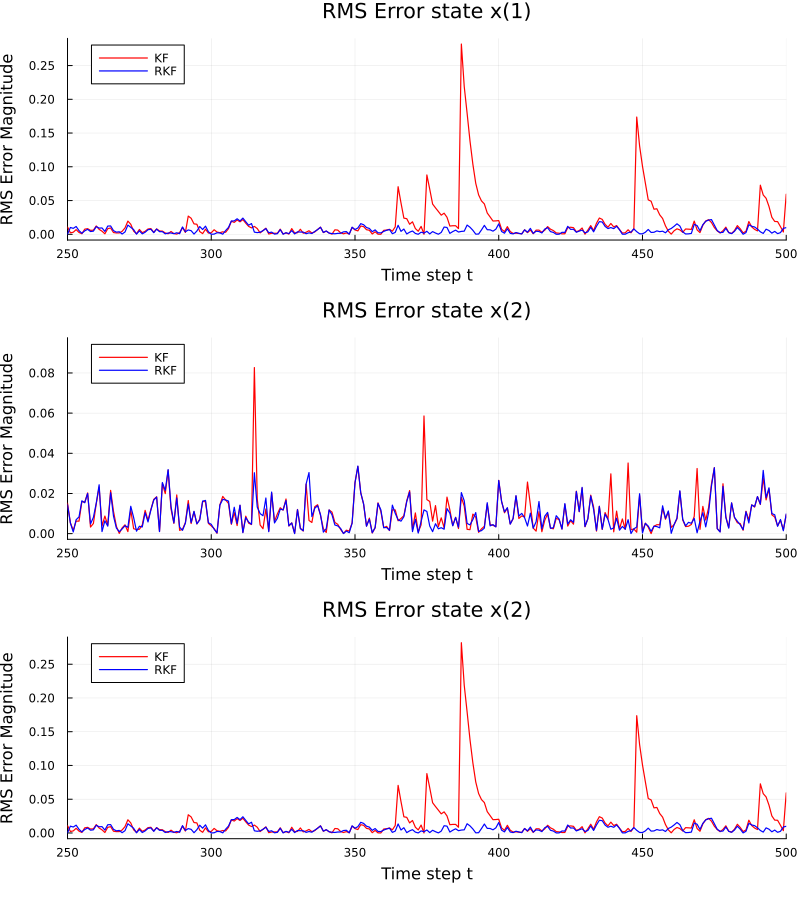

In [66]:
t=0:N
plot(layout=(3,1),size=(800,900))
plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=1)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=1,legend=:topleft)
title!("RMS Error state x(1)", subplot=1,fontsize=12)
xlabel!("Time step t", subplot=1)
ylabel!("RMS Error Magnitude",subplot=1)
xlims!(subplot=1,(250,500))


plot!(t,RMS_KF[2,:],color=:red,linewidth=1.2,label="KF",subplot=2)
plot!(t,RMS_RKF[2,:],color=:blue,linewidth=1.2,label="RKF",subplot=2,legend=:topleft)
title!("RMS Error state x(2)", subplot=2,fontsize=12)
xlabel!("Time step t", subplot=2)
ylabel!("RMS Error Magnitude",subplot=2)
xlims!(subplot=2,(250,500))

plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=3)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=3,legend=:topleft)
title!("RMS Error state x(2)", subplot=3,fontsize=12)
xlabel!("Time step t", subplot=3)
ylabel!("RMS Error Magnitude",subplot=3)
xlims!(subplot=3,(250,500))

In [73]:
# calculting the computation time of OSQP solver

Random.seed!(20230914)

N = 1000
lambda = 2
x0 = 5*ones(3,1)
P0 = I(3)
Q = Diagonal([1/40,1/10,1/5])
R = 0.5*I(2)

v = (randn(N,3)*cholesky(Q).L)' # process noise

# Vector for full state history:
x = zeros(3,N+1)
x[:,1] = x0 + cholesky(P0).L * randn(3)

u = zeros(N)
u[1:500] .= 5
u[501:end] .= 2
alpha1 = 0.1
alpha2 = 0.5
alpha3 = 0.2

A = [1-alpha1 0 0;
    0 1-alpha2 0;
    alpha1 alpha2 1-alpha3]
B = [0.5; 0.5; 0]

# Vector for full measurement history:
z = zeros(2,N+1)
H = [1 0 0; 0 0 1]
w = (randn(N+1,2)*cholesky(R).L)' # measurement noise

# Additional noise term: Simulate sensor failures
y = zeros(2,N+1)
numberofOnes = Int(N/20)

indexes = randperm(N)
for i in 1:numberofOnes
    y[1,indexes[i]] = 25*randn()
end

indexes = randperm(N)
for i in 1:numberofOnes
    y[2,indexes[i]] = 25*randn()
end

# Simulation
for k in 2:N+1
    x[:,k] = A*x[:,k-1] + B*u[k-1] + v[:,k-1]
    z[:,k] = H*x[:,k] + w[:,k] + y[:,k]
end

# Kalman Filter 
x_hat = zeros(3,N+1)
x_hat[:,1] = x0
P_hat = P0
R_inv = inv(R)
for k in 2:N+1
    x_p = A*x_hat[:,k-1] + B*u[k-1]
    P_p = A*P_hat*A' + Q

    P_hat = inv(inv(P_p)+H'*R_inv*H)
    x_hat[:,k] = x_p + P_hat*H'*R_inv*(z[:,k]-H*x_p)
end

# Robust Kalman Filter 
Run_time_Hist = []
x_hat_RKF = zeros(3,N+1)
x_hat_RKF[:,1] = x0
P_hat_RKF = P0

model_osqp = OSQP.Model()
for k in 2:N+1
    x_p_RKF = A*x_hat_RKF[:,k-1] + B*u[k-1];
    P_p_RKF = A*P_hat_RKF*A' + Q;

    P_hat_RKF = inv(inv(P_p_RKF)+H'*R_inv*H);

    L = P_hat_RKF*H'*inv(H*P_hat_RKF*H'+R);
    myQ = (I(2)-H*L)'*R_inv*(I(2)-H*L)+L'*inv(P_hat_RKF)*L;
    e_k = z[:,k]-H*x_p_RKF;

    
    H_inv = inv(myQ)
    f = myQ*e_k
    h = -H_inv*f

    OSQP.setup!(model_osqp; P=sparse(H_inv), q=h, A=sparse(Diagonal(ones(length(h)))),l=-ones(length(h)),u=ones(length(h)),eps_abs=1e-6,eps_rel=1e-6,verbose=0)
    start_time = time()
    results = OSQP.solve!(model_osqp)
    run_time = time() - start_time
    sol = results.x

    Run_time_Hist = [Run_time_Hist; run_time]
    sol = H_inv*(f-sol);

    x_hat_RKF[:,k] = x_p_RKF + L*(e_k-sol);
end

# evaluate error
RMS_KF = zeros(3,N+1);
for i in 1:3
    RMS_KF[i,:] = sqrt.((x[i,:].-x_hat[i,:]).^2/N);
end

RMS_RKF = zeros(3,N+1);
for i in 1:3
    RMS_RKF[i,:] = sqrt.((x[i,:].-x_hat_RKF[i,:]).^2/N);
end

for i in 1:3
    imp = 100-100/mean(RMS_KF[i,:])*mean(RMS_RKF[i,:]);
    println("RMS error of state $i estimate is reduced by $imp percent")
end

computation_time = mean(Run_time_Hist)
println("The average computation of our OSQP solver is $computation_time seconds")

RMS error of state 1 estimate is reduced by 64.7039442836047 percent
RMS error of state 2 estimate is reduced by 11.345932100385738 percent
RMS error of state 3 estimate is reduced by 54.68955163329725 percent
The average computation of our OSQP solver is 5.067586898803711e-6 seconds


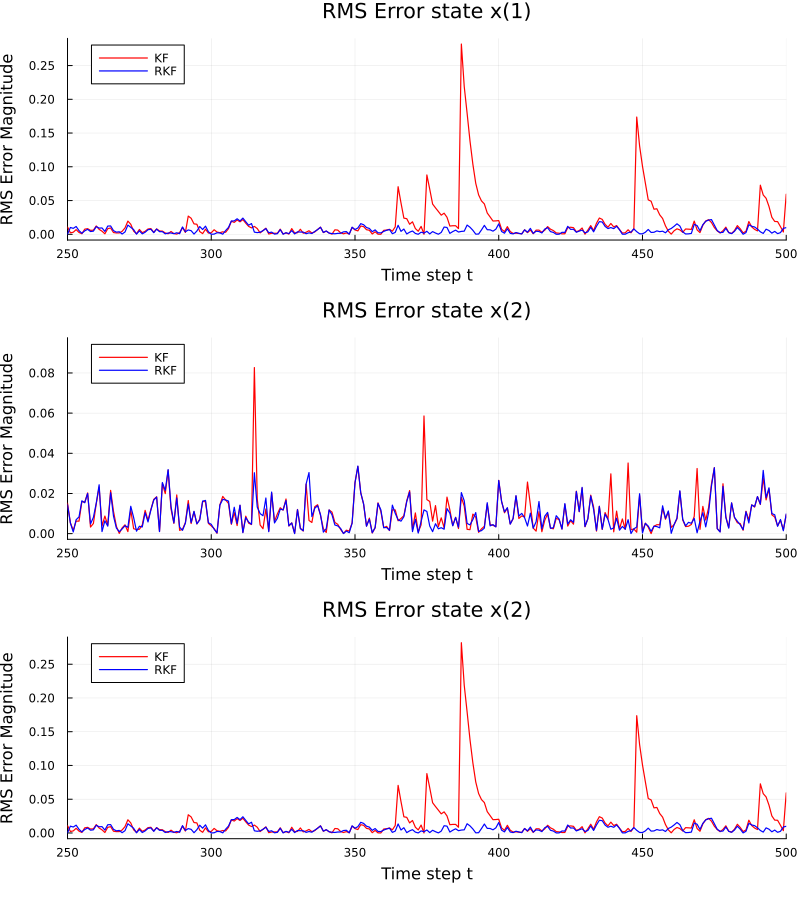

In [68]:
t=0:N
plot(layout=(3,1),size=(800,900))
plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=1)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=1,legend=:topleft)
title!("RMS Error state x(1)", subplot=1,fontsize=12)
xlabel!("Time step t", subplot=1)
ylabel!("RMS Error Magnitude",subplot=1)
xlims!(subplot=1,(250,500))


plot!(t,RMS_KF[2,:],color=:red,linewidth=1.2,label="KF",subplot=2)
plot!(t,RMS_RKF[2,:],color=:blue,linewidth=1.2,label="RKF",subplot=2,legend=:topleft)
title!("RMS Error state x(2)", subplot=2,fontsize=12)
xlabel!("Time step t", subplot=2)
ylabel!("RMS Error Magnitude",subplot=2)
xlims!(subplot=2,(250,500))

plot!(t,RMS_KF[1,:],color=:red,linewidth=1.2,label="KF",subplot=3)
plot!(t,RMS_RKF[1,:],color=:blue,linewidth=1.2,label="RKF",subplot=3,legend=:topleft)
title!("RMS Error state x(2)", subplot=3,fontsize=12)
xlabel!("Time step t", subplot=3)
ylabel!("RMS Error Magnitude",subplot=3)
xlims!(subplot=3,(250,500))